In [9]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# CARGO EL ARCHIVO Y MODIFICO EL NOMBRE DE LA COLUMNA QUE CONTIENE LOS NODOS:
vientos = pd.read_csv("C:/Users/Christian/Desktop/CLASES_2DOSEM/clase_6/Datos-Vientos.csv", sep=";")
vientos.rename(columns={"Kts": "Nodos"}, inplace=True)

# DETERMINO EN LISTAS LAS DIRECCIONES Y LOS INTERVALOS:
direcciones = [0, 10, 20, 50, 70, 90, 110, 140, 160, 180, 200, 230, 250, 270, 290, 320, 340, 360]
rangos = [(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)]
datos_puros = pd.DataFrame(index=direcciones)

# ITERO CADA ELEMENTO DE DIRECCIONES Y RANGOS PARA IR CREANDO MI DATAFRAME:
for direccion in direcciones:
    for rango in rangos:
        filtro = (vientos['DIRECCION'] == direccion) & (vientos['Nodos'] > rango[0]) & (vientos['Nodos'] <= rango[1])
        cantidad_nodos = vientos.loc[filtro, 'Nodos'].count()
        datos_puros.loc[direccion, f"{rango[0]}-{rango[1]}"] = cantidad_nodos

datos_puros = datos_puros.astype(int)
datos_puros.insert(0, "Rad", datos_puros.index * (np.pi / 180))
datos_puros["Rad"] = datos_puros["Rad"].round(2)
direcciones_pista = list(range(0, 361, 10))

def viento_cruzado(direcciones_pista):
    v_c_list = []  
    for w in direcciones_pista:
        v_c = pd.DataFrame(index=direcciones)
        for direccion in datos_puros.index:
            for rango in rangos:
                angulo_en_radianes = (direccion - w) * np.pi / 180
                result = np.abs(rango[1] * np.sin(angulo_en_radianes))
                result_dec = round(result, 2)
                v_c.loc[direccion, f"{rango[0]}-{rango[1]}"] = result_dec
        v_c_list.append(v_c)  
    return v_c_list

def frecuencia_admisible():
    v_c_list = viento_cruzado(direcciones_pista)
    maxim = float('-inf')
    maxim_w = None

    for idx, w in enumerate(direcciones_pista):  # Añadir enumerate para obtener índice y valor
        v_c = v_c_list[idx]  # Obtener el v_c correspondiente a la iteración actual
        f_ad = pd.DataFrame(index=direcciones)
        
        for direccion in v_c.index:
            for rango in rangos:
                x = v_c.loc[direccion, f"{rango[0]}-{rango[1]}"]
                if x < valor_limite:
                    valor_cantidad_nodos = datos_puros.loc[direccion, f"{rango[0]}-{rango[1]}"]
                    f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = valor_cantidad_nodos
                else:
                    f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = 0
        
        f_ad = f_ad.astype(int)
        
        # Actualizar maxim y maxim_w si se encuentra un nuevo máximo
        if f_ad.sum().sum() > maxim:
            maxim = f_ad.sum().sum()
            maxim_w = w
            maxim_df = f_ad.copy()
    
    return maxim_df, maxim, maxim_w

def coheficiente():
    maxim_df,maxim, maxim_w = frecuencia_admisible()
    viento_calma = 10853
    suma_total_frec = datos_puros.drop(columns=["Rad"]).sum().sum()
    cohe = ((maxim + viento_calma) / (viento_calma + suma_total_frec) * 100).round(2)
    resultado_texto = f"La pista con dirección {maxim_w} tiene este coeficiente: {cohe}%"
      
    return resultado_texto

def grafico(nuevo_frame):
    maxim_df, maxim, maxim_w = frecuencia_admisible()
    frecuencias = maxim_df.sum(axis=1).tolist()
    # Crea una lista de tuplas con los valores de direcciones y frecuencias
    data = list(zip(direcciones, frecuencias))
    # Ordena la lista por el valor de direcciones
    data_sorted = sorted(data, key=lambda x: x[0])
    tupla_maxima = max(data, key=lambda x: x[1])
    dir_pista = tupla_maxima[0]
    dir_pista_rad = np.radians(dir_pista)
    dir_opuesto=(dir_pista + 180) % 360
    dir_opuesto_rad=np.radians(dir_opuesto)

    # Crea el gráfico con la lista ordenada
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    bars = ax.bar([d * (2 * np.pi / 360) for d, _ in data_sorted], [f for _, f in data_sorted], width=0.35, bottom=0.0)
    rect = plt.Rectangle((maxim_w * (2 * np.pi / 360), 0), 0.2, 1, color='r', alpha=0.5)
    ax.add_patch(rect)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks([d * (2 * np.pi / 360) for d in range(0, 361, 45)])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
    ax.set_rlabel_position(0)
    ax.plot([dir_opuesto_rad,dir_pista_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)
    ax.plot([dir_pista_rad,dir_opuesto_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)

    canvas = FigureCanvasTkAgg(fig, master=nuevo_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
   
def validate_entry(text):
    return text.isdigit() and len(text) <= 5

def on_combobox_select(event):
    global valor_limite
    valor_limite = int(lista.get())

def on_button_click():
    maximo_coheficiente = coheficiente()
    mensaje.config(text=f"{maximo_coheficiente}")

############## TKINTER ############
window = tk.Tk()
window.title("ROSA DE VIENTO")

###########################PRIMER_FRAME#############################
frame1 = tk.Frame(window)
frame1.pack(side="top", fill="x")

titulo_label = tk.Label(frame1, text="Selecciona una opción:")
titulo_label.pack(side="left", padx=10, pady=10)

lista = ttk.Combobox(frame1, values=["10", "13", "20"])
lista.pack(side="left", padx=10, pady=10)
lista.bind("<<ComboboxSelected>>", on_combobox_select)

button_graf = tk.Button(frame1, text="GRAFICO", command=lambda: grafico(nuevo_frame))
button_graf.pack(side="left", padx=10, pady=10)
button_out = tk.Button(frame1, text="CALCULAR", command=on_button_click)
button_out.pack(side="left", padx=10, pady=10)

mensaje = tk.Label(frame1, text="")
mensaje.pack(side="left", padx=10, pady=10)

###########################SEGUNDO_FRAME#############################
frame_superior = tk.Frame(window, width=200, height=10)
frame_superior.place(x=400,y=60)

# Agregar el título al nuevo frame
titulo_superior = tk.Label(frame_superior, text="FRECUENCIAS POR NODOS")
titulo_superior.pack(side="top")

frame2 = tk.Frame(window,bg="blue",width=850, height=100)
frame2.pack(side="left", fill="both", expand=False,padx=10,pady=50)

# Create the scrollbar for the second frame
scrollbar = tk.Scrollbar(frame2)
scrollbar.pack(side="right", fill="y")

# Create the canvas for the second frame
canvas = tk.Canvas(frame2, yscrollcommand=scrollbar.set,width=850)
canvas.pack(side="left", fill="both", expand=True)

# Configure the scrollbar to affect only the second frame
scrollbar.config(command=canvas.yview)

# Create the inner frame for the second frame
inner_frame = tk.Frame(canvas,width=850)
canvas.create_window((0, 0), window=inner_frame, anchor="nw")
titulo_dir=tk.Label(frame2, text="Dirección")
titulo_dir.place(x=0,y=10)

for i in range(1,37):
    grados = i * 10  # Etiquetas direcciones
    label = tk.Label(inner_frame, text=grados, width=4)
    label.grid(row=i, column=0, padx=(0, 2), pady=5, sticky="e")

    # Agregar Entry widgets
    for j, rango in enumerate([(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)], start=1):
        entry = tk.Entry(inner_frame, validate="key", width=9)
        entry['validatecommand'] = (entry.register(validate_entry), '%P')
        entry.grid(row=i, column=j, padx=1, pady=5)

        # Agregar etiquetas a cada columna
        etiqueta = tk.Label(inner_frame, text=f"{rango[0]}-{rango[1]}", width=9)
        etiqueta.grid(row=0, column=j, padx=10, pady=5)

# Configure the canvas to resize with the inner frame
inner_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

nuevo_frame = tk.Frame(window, width=500, height=100, bg="lightblue")
nuevo_frame.pack(side="right", fill="both", expand=False, padx=10, pady=50)    

window.mainloop()


     0-3   3-6  6-10  10-16  16-21  21-27  27-33  33-40  40-50
10   176    15     0      0      0      0      0      0      0
20    32   284   294    481    170     35      1      0      0
30     0     0     0      0      0      0      0      0      0
40     0     0     0      0      0      0      0      0      0
50    29   223   198    267     88      8      2      0      0
60     0     0     0      0      0      0      0      0      0
70    18   181   182    200     34     12      0      0      0
80     0     0     0      0      0      0      0      0      0
90    22   183   150    144     42     16      0      0      0
100    0     0     0      0      0      0      0      0      0
110   27   236   177    308    139     28      0      0      0
120    0     0     0      0      0      0      0      0      0
130    0     0     0      0      0      0      0      0      0
140   31   249   159    204     35     10      0      0      0
150    0     0     0      0      0      0      0      0

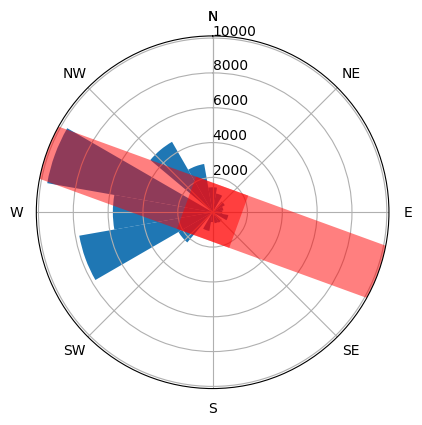

In [16]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
"""
# CARGO EL ARCHIVO Y MODIFICO EL NOMBRE DE LA COLUMNA QUE CONTIENE LOS NODOS:
vientos = pd.read_csv("C:/Users/Christian/Desktop/CLASES_2DOSEM/clase_6/Datos-Vientos.csv", sep=";")
vientos.rename(columns={"Kts": "Nodos"}, inplace=True)
"""
# DETERMINO EN LISTAS LAS DIRECCIONES Y LOS INTERVALOS:
direcciones = range(10,361,10)
rangos = [(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)]
#datos_puros = pd.DataFrame(index=direcciones)
"""
# ITERO CADA ELEMENTO DE DIRECCIONES Y RANGOS PARA IR CREANDO MI DATAFRAME:
for direccion in direcciones:
    for rango in rangos:
        filtro = (vientos['DIRECCION'] == direccion) & (vientos['Nodos'] > rango[0]) & (vientos['Nodos'] <= rango[1])
        cantidad_nodos = vientos.loc[filtro, 'Nodos'].count()
        datos_puros.loc[direccion, f"{rango[0]}-{rango[1]}"] = cantidad_nodos

datos_puros = datos_puros.astype(int)
datos_puros.insert(0, "Rad", datos_puros.index * (np.pi / 180))
datos_puros["Rad"] = datos_puros["Rad"].round(2)
"""
direcciones_pista = list(range(0, 361, 10))

def viento_cruzado(direcciones_pista):
    v_c_list = []  
    for w in direcciones_pista:
        v_c = pd.DataFrame(index=direcciones)
        for direccion in datos_puros.index:
            for rango in rangos:
                angulo_en_radianes = (direccion - w) * np.pi / 180
                result = np.abs(rango[1] * np.sin(angulo_en_radianes))
                result_dec = round(result, 2)
                v_c.loc[direccion, f"{rango[0]}-{rango[1]}"] = result_dec
        v_c_list.append(v_c)  
    return v_c_list

def frecuencia_admisible():
    v_c_list = viento_cruzado(direcciones_pista)
    maxim = float('-inf')
    maxim_w = None

    for idx, w in enumerate(direcciones_pista):  # Añadir enumerate para obtener índice y valor
        v_c = v_c_list[idx]  # Obtener el v_c correspondiente a la iteración actual
        f_ad = pd.DataFrame(index=direcciones)
        
        for direccion in v_c.index:
            for rango in rangos:
                x = v_c.loc[direccion, f"{rango[0]}-{rango[1]}"]
                if x < valor_limite:
                    if direccion in df.index:
                        valor_cantidad_nodos = df.loc[direccion, f"{rango[0]}-{rango[1]}"]
                        f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = valor_cantidad_nodos
                    else:
                        f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = 0
                else:
                    f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = 0
        
        f_ad = f_ad.astype(int)
        
        # Actualizar maxim y maxim_w si se encuentra un nuevo máximo
        if f_ad.sum().sum() > maxim:
            maxim = f_ad.sum().sum()
            maxim_w = w
            maxim_df = f_ad.copy()
    
    return maxim_df, maxim, maxim_w

def coheficiente():
    maxim_df,maxim, maxim_w = frecuencia_admisible()
    viento_calma = 10853
    suma_total_frec = datos_puros.drop(columns=["Rad"]).sum().sum()
    cohe = ((maxim + viento_calma) / (viento_calma + suma_total_frec) * 100).round(2)
    resultado_texto = f"La pista con dirección {maxim_w} tiene este coeficiente: {cohe}%"
      
    return resultado_texto

def grafico(nuevo_frame):
    maxim_df, maxim, maxim_w = frecuencia_admisible()
    frecuencias = maxim_df.sum(axis=1).tolist()
    # Crea una lista de tuplas con los valores de direcciones y frecuencias
    data = list(zip(direcciones, frecuencias))
    # Ordena la lista por el valor de direcciones
    data_sorted = sorted(data, key=lambda x: x[0])
    tupla_maxima = max(data, key=lambda x: x[1])
    dir_pista = tupla_maxima[0]
    dir_pista_rad = np.radians(dir_pista)
    dir_opuesto=(dir_pista + 180) % 360
    dir_opuesto_rad=np.radians(dir_opuesto)

    # Crea el gráfico con la lista ordenada
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    bars = ax.bar([d * (2 * np.pi / 360) for d, _ in data_sorted], [f for _, f in data_sorted], width=0.35, bottom=0.0)
    rect = plt.Rectangle((maxim_w * (2 * np.pi / 360), 0), 0.2, 1, color='r', alpha=0.5)
    ax.add_patch(rect)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks([d * (2 * np.pi / 360) for d in range(0, 361, 45)])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
    ax.set_rlabel_position(0)
    ax.plot([dir_opuesto_rad,dir_pista_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)
    ax.plot([dir_pista_rad,dir_opuesto_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)

    canvas = FigureCanvasTkAgg(fig, master=nuevo_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
df = pd.DataFrame()    
    
def validate_entry(text):
    return text.isdigit() and len(text) <= 5 or text == ""

def on_combobox_select(event):
    global valor_limite
    valor_limite = int(lista.get())

def calcular():
    global df
    data = []
    for fila in entries:
        row_data = []
        for entry in fila:
            value = entry.get()
            if value:
                row_data.append(int(value))
            else:
                row_data.append(0)
        data.append(row_data)

    # Crear el DataFrame
    if data:
        column_labels = [f"{rango[0]}-{rango[1]}" for rango in rangos]

        df = pd.DataFrame(data, columns=column_labels,index=direcciones)
        print(df)
    else:
        print("No hay datos para mostrar.")
    maximo_coheficiente = coheficiente()
    mensaje.config(text=f"{maximo_coheficiente}")

############## TKINTER ############
window = tk.Tk()
window.title("ROSA DE VIENTO")

###########################PRIMER_FRAME#############################
frame1 = tk.Frame(window)
frame1.pack(side="top", fill="x")

titulo_label = tk.Label(frame1, text="Selecciona una opción:")
titulo_label.pack(side="left", padx=10, pady=10)

lista = ttk.Combobox(frame1, values=["10", "13", "20"])
lista.pack(side="left", padx=10, pady=10)
lista.bind("<<ComboboxSelected>>", on_combobox_select)

button_graf = tk.Button(frame1, text="GRAFICO", command=lambda: grafico(nuevo_frame))
button_graf.pack(side="left", padx=10, pady=10)
button_out = tk.Button(frame1, text="CALCULAR", command=calcular)
button_out.pack(side="left", padx=10, pady=10)

mensaje = tk.Label(frame1, text="")
mensaje.pack(side="left", padx=10, pady=10)

###########################SEGUNDO_FRAME#############################
frame_superior = tk.Frame(window, width=200, height=10)
frame_superior.place(x=400,y=60)

# Agregar el título al nuevo frame
titulo_superior = tk.Label(frame_superior, text="FRECUENCIAS POR NODOS")
titulo_superior.pack(side="top")

frame2 = tk.Frame(window,bg="blue",width=850, height=100)
frame2.pack(side="left", fill="both", expand=False,padx=10,pady=50)

# Create the scrollbar for the second frame
scrollbar = tk.Scrollbar(frame2)
scrollbar.pack(side="right", fill="y")

# Create the canvas for the second frame
canvas = tk.Canvas(frame2, yscrollcommand=scrollbar.set,width=850)
canvas.pack(side="left", fill="both", expand=True)

# Configure the scrollbar to affect only the second frame
scrollbar.config(command=canvas.yview)

# Create the inner frame for the second frame
inner_frame = tk.Frame(canvas,width=850)
canvas.create_window((0, 0), window=inner_frame, anchor="nw")
titulo_dir=tk.Label(frame2, text="Dirección")
titulo_dir.place(x=0,y=10)

entries=[]
for i in range(10,361,10):
    #grados = i * 10  # Etiquetas 
    label = tk.Label(inner_frame, text=i, width=4)
    label.grid(row=i, column=0, padx=(0, 2), pady=5, sticky="e")
    row=[]
    # Agregar Entry widgets
    for j, rango in enumerate([(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)], start=1):
        entry = tk.Entry(inner_frame, validate="key", width=9)
        entry['validatecommand'] = (entry.register(validate_entry), '%P')
        entry.grid(row=i, column=j, padx=1, pady=5)
        row.append(entry)
        # Agregar etiquetas a cada columna
        etiqueta = tk.Label(inner_frame, text=f"{rango[0]}-{rango[1]}", width=9)
        etiqueta.grid(row=0, column=j, padx=10, pady=5)
    entries.append(row)

# Configure the canvas to resize with the inner frame
inner_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

nuevo_frame = tk.Frame(window, width=500, height=100, bg="lightblue")
nuevo_frame.pack(side="right", fill="both", expand=False, padx=10, pady=50)    

window.mainloop()


     0-3  3-6  6-10  10-16  16-21  21-27  27-33  33-40  40-50
10     0    0     0      0      0      0      0      0      0
20     0    0     0      0      0      0      0      0      0
30     0    0     0      0      0      0      0      0      0
40     0    0     0      0      0      0      0      0      0
50     0    0     0      0      0      0      0      0      0
60     0    0     0      0      0      0      0      0      0
70     0    0     0      0      0      0      0      0      0
80     0    0     0      0      0      0      0      0      0
90     0    0     0      0      0      0      0      0      0
100    0    0     0      0      0      0      0      0      0
110    0    0     0      0      0      0      0      0      0
120    0    0     0      0      0      0      0      0      0
130    0    0     0      0      0      0      0      0      0
140    0    0     0      0      0      0      0      0      0
150    0    0     0      0      0      0      0      0      0
160    0

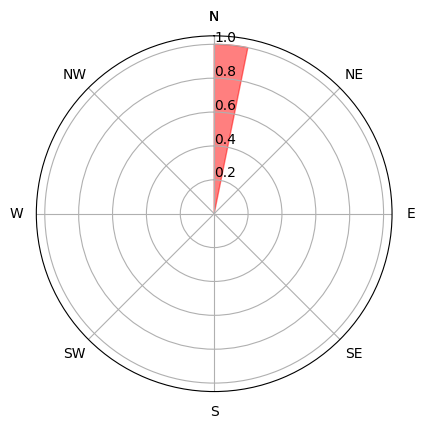

In [11]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# DETERMINO EN LISTAS LAS DIRECCIONES Y LOS INTERVALOS:
direcciones = range(10,361,10)
rangos = [(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)]
direcciones_pista = list(range(0, 361, 10))
valor_limite = None

#FUNCION QUE CREA UN CONJUNTO DE DATAFRAMES PARA CADA DIRECCION QUE TOME LA PISTA (direcciones_pista)
def viento_cruzado(direcciones_pista):
    v_c_list = []  
    for w in direcciones_pista:
        v_c = pd.DataFrame(index=direcciones)
        for direccion in df.index:
            for rango in rangos:
                angulo_en_radianes = (direccion - w) * np.pi / 180
                result = np.abs(rango[1] * np.sin(angulo_en_radianes))
                result_dec = round(result, 2)
                v_c.loc[direccion, f"{rango[0]}-{rango[1]}"] = result_dec
        v_c_list.append(v_c)  
    return v_c_list
    
#FUNCION QUE TOMA TODOS LOS DATAFRAMES GENERADOS EN LA FUNCION ANTERIOR Y COMPARA CON LAS RESTRICCIONES GENERANDO OTRO CONJUNTO DE DATAFRAMES QUE
#CONTIENEN LAS FRECUENCIAS SEGUN LAS RESTRICCIONES.
def frecuencia_admisible():
    v_c_list = viento_cruzado(direcciones_pista)
    maxim = float('-inf')
    maxim_w = None
    maxim_df = None
    maxim_v_c=None

    for idx, w in enumerate(direcciones_pista):
        v_c = v_c_list[idx]
        f_ad = pd.DataFrame(index=direcciones)

        for direccion in v_c.index:
            for rango in rangos:
                if direccion in v_c.index and f"{rango[0]}-{rango[1]}" in v_c.columns:
                    x = v_c.loc[direccion, f"{rango[0]}-{rango[1]}"]
                else:
                    x = 0
                if valor_limite is not None and x < valor_limite:
                    if direccion in df.index:
                        valor_cantidad_nodos = df.loc[direccion, f"{rango[0]}-{rango[1]}"]
                        f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = valor_cantidad_nodos
                    else:
                        f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = 0
                else:
                    f_ad.loc[direccion, f"{rango[0]}-{rango[1]}"] = 0

        f_ad = f_ad.astype(int)

        # Actualizar maxim y maxim_w si se encuentra un nuevo máximo
        
        if f_ad.sum().sum() > maxim:
            maxim = f_ad.sum().sum()
            maxim_w = w
            maxim_df = f_ad.copy()
            maxim_v_c=v_c.copy()           
    return maxim_df, maxim, maxim_w, maxim_v_c
    
#ESTA FUNCION TOMA EL DATAFRAME DE LA FUNCION ANTERIOR QUE HAYA TENIDO EL MAYOR RESULTADO EN LA SUMA DE SUS VALORES Y PROCEDE CON EL CALCULO DEL COHEFI.
def coheficiente():
    maxim_df,maxim, maxim_w, maxim_v_c = frecuencia_admisible()
    viento_calma = 10853
    suma_total_frec = df.sum().sum()
    cohe = ((maxim + viento_calma) / (viento_calma + suma_total_frec) * 100).round(2)
    resultado_texto = f"La pista con dirección {maxim_w} tiene este coeficiente: {cohe}%"
      
    return resultado_texto
    
############################ FUNCIONES QUE SE ACTIVAN CON LOS WIDGETS ######################################    
df = pd.DataFrame()    
    
def validate_entry(text):
    return text.isdigit() and len(text) <= 5 or text == ""

def on_combobox_select(event):
    global valor_limite
    valor_limite = int(lista.get())

def calcular():
    global df,maxim_df,maxim_v_c
    selected_value = lista.get()
    
    if not selected_value:
        messagebox.showinfo("Error", "Por favor, eliga una opción para realizar los cálculos.")
        return
    data = []    
    for fila in entries:
        row_data = []
        for entry in fila:
            value = entry.get()
            if value:
                row_data.append(int(value))
            else:
                row_data.append(0)
        data.append(row_data)

    # Crear el DataFrame
    if data:
        column_labels = [f"{rango[0]}-{rango[1]}" for rango in rangos]

        df = pd.DataFrame(data, columns=column_labels,index=direcciones)
        print(df)
        
        _, _, _, maxim_v_c = frecuencia_admisible()
        button_guardar_excel.config(state=tk.NORMAL)
    else:
        print("No hay datos para mostrar.")
    maximo_coheficiente = coheficiente()
    mensaje.config(text=f"{maximo_coheficiente}")
    
    if valor_limite is not None:
        grafico(nuevo_frame)

#FUNCION QUE GENERA EL GRAFICO.
def grafico(nuevo_frame):
    for widget in nuevo_frame.winfo_children():
        widget.destroy()
    maxim_df, maxim, maxim_w, maxim_v_c = frecuencia_admisible()
    frecuencias = maxim_df.sum(axis=1).tolist()
    # Crea una lista de tuplas con los valores de direcciones y frecuencias
    data = list(zip(direcciones, frecuencias))
    # Ordena la lista por el valor de direcciones
    data_sorted = sorted(data, key=lambda x: x[0])
    tupla_maxima = max(data, key=lambda x: x[1])
    dir_pista = tupla_maxima[0]
    dir_pista_rad = np.radians(dir_pista)
    dir_opuesto=(dir_pista + 180) % 360
    dir_opuesto_rad=np.radians(dir_opuesto)

    # Crea el gráfico con la lista ordenada
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    bars = ax.bar([d * (2 * np.pi / 360) for d, _ in data_sorted], [f for _, f in data_sorted], width=0.35, bottom=0.0)
    rect = plt.Rectangle((maxim_w * (2 * np.pi / 360), 0), 0.2, 1, color='r', alpha=0.5)
    ax.add_patch(rect)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks([d * (2 * np.pi / 360) for d in range(0, 361, 45)])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
    ax.set_rlabel_position(0)
    ax.plot([dir_opuesto_rad,dir_pista_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)
    ax.plot([dir_pista_rad,dir_opuesto_rad], [0, tupla_maxima[1]], color='red', linewidth=40,alpha=0.5)

    canvas = FigureCanvasTkAgg(fig, master=nuevo_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
maxim_v_c = None
def guardar_excel():
    global maxim_v_c

    if maxim_v_c is not None:
        # Pide al usuario la ubicación y nombre del archivo Excel
        file_path = tk.filedialog.asksaveasfilename(defaultextension=".xlsx", filetypes=[("Archivos Excel", "*.xlsx")])

        if file_path:
            # Guarda el DataFrame en un archivo Excel
            maxim_v_c.to_excel(file_path, index=True)
            messagebox.showinfo("Éxito", "Archivo Excel guardado exitosamente.")
        else:
            messagebox.showinfo("Cancelado", "Guardado de archivo cancelado.")
    else:
        messagebox.showinfo("Error", "Primero debes calcular las frecuencias antes de guardar un archivo Excel.")
        
################################################################# TKINTER ############################################################################
window = tk.Tk()
window.title("ROSA DE VIENTO")

##################################################################PRIMER_FRAME#######################################################################
frame1 = tk.Frame(window)
frame1.pack(side="top", fill="x")

titulo_label = tk.Label(frame1, text="Selecciona una opción:")
titulo_label.pack(side="left", padx=10, pady=10)

lista = ttk.Combobox(frame1, values=["10", "13", "20"])
lista.pack(side="left", padx=10, pady=10)
lista.bind("<<ComboboxSelected>>", on_combobox_select)

button_graf = tk.Button(frame1, text="CALCULO", command=calcular)
button_graf.pack(side="left", padx=10, pady=10)
button_guardar_excel = tk.Button(frame1, text="Guardar Excel", command=guardar_excel,state=tk.DISABLED)
button_guardar_excel.pack(side="left", padx=20, pady=10)
mensaje = tk.Label(frame1, text="")
mensaje.pack(side="left", padx=10, pady=10)

########################################################################SEGUNDO_FRAME#################################################################
frame_superior = tk.Frame(window, width=200, height=10)
frame_superior.place(x=400,y=60)

# Agregar el título al nuevo frame
titulo_superior = tk.Label(frame_superior, text="FRECUENCIAS POR NODOS")
titulo_superior.pack(side="top")

frame2 = tk.Frame(window,bg="blue",width=850, height=100)
frame2.pack(side="left", fill="both", expand=False,padx=10,pady=50)

# Create the scrollbar for the second frame
scrollbar = tk.Scrollbar(frame2)
scrollbar.pack(side="right", fill="y")

# Create the canvas for the second frame
canvas = tk.Canvas(frame2, yscrollcommand=scrollbar.set,width=850)
canvas.pack(side="left", fill="both", expand=True)

# Configure the scrollbar to affect only the second frame
scrollbar.config(command=canvas.yview)

# Create the inner frame for the second frame
inner_frame = tk.Frame(canvas,width=850)
canvas.create_window((0, 0), window=inner_frame, anchor="nw")
titulo_dir=tk.Label(frame2, text="Dirección")
titulo_dir.place(x=0,y=10)

entries=[]
for i in range(10,361,10):
    #grados = i * 10  # Etiquetas 
    label = tk.Label(inner_frame, text=i, width=4)
    label.grid(row=i, column=0, padx=(0, 2), pady=5, sticky="e")
    row=[]
    # Agregar Entry widgets
    for j, rango in enumerate([(0, 3), (3, 6), (6, 10), (10, 16), (16, 21), (21, 27), (27, 33), (33, 40), (40, 50)], start=1):
        entry = tk.Entry(inner_frame, validate="key", width=9)
        entry['validatecommand'] = (entry.register(validate_entry), '%P')
        entry.grid(row=i, column=j, padx=1, pady=5)
        row.append(entry)
        # Agregar etiquetas a cada columna
        etiqueta = tk.Label(inner_frame, text=f"{rango[0]}-{rango[1]}", width=9)
        etiqueta.grid(row=0, column=j, padx=10, pady=5)
    entries.append(row)

inner_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

############################################################FRAME DEL GRAFICO###########################################################################
nuevo_frame = tk.Frame(window, width=500, height=100, bg="lightblue")
nuevo_frame.pack(side="right", fill="both", expand=False, padx=10, pady=50)    

window.mainloop()
